https://www.pymc.io/projects/examples/en/latest/causal_inference/difference_in_differences.html

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
def outcome(t, control_intercept, treat_intercept_delta, trend, Δ, group, treated):
    return control_intercept + (treat_intercept_delta * group) + (t * trend) + (Δ * treated * group)

In [4]:
def is_treated(t, intervention_time, group):
    return (t > intervention_time) * group

In [5]:
# true parameters
control_intercept = 1
treat_intercept_delta = 0.25
trend = 1
Δ = 0.5
intervention_time = 0.5

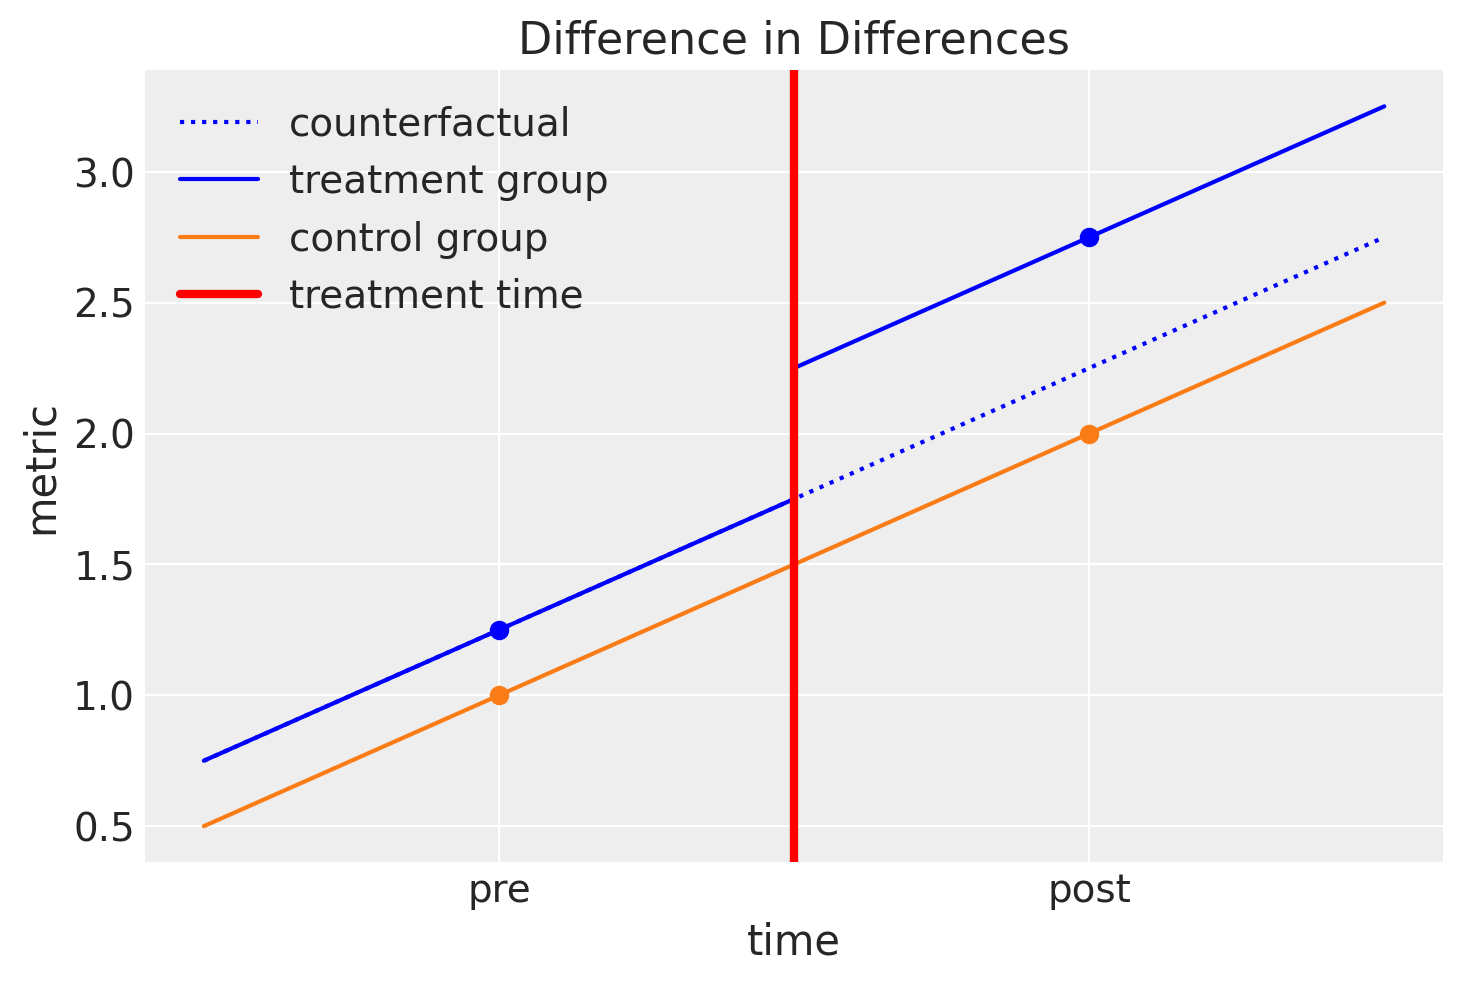

In [6]:
fig, ax = plt.subplots()
ti = np.linspace(-0.5, 1.5, 1000)
ax.plot(
    ti,
    outcome(
        ti,
        control_intercept,
        treat_intercept_delta,
        trend,
        Δ=0,
        group=1,
        treated=is_treated(ti, intervention_time, group=1),
    ),
    color="blue",
    label="counterfactual",
    ls=":",
)
ax.plot(
    ti,
    outcome(
        ti,
        control_intercept,
        treat_intercept_delta,
        trend,
        Δ,
        group=1,
        treated=is_treated(ti, intervention_time, group=1),
    ),
    color="blue",
    label="treatment group",
)
ax.plot(
    ti,
    outcome(
        ti,
        control_intercept,
        treat_intercept_delta,
        trend,
        Δ,
        group=0,
        treated=is_treated(ti, intervention_time, group=0),
    ),
    color="C1",
    label="control group",
)
ax.axvline(x=intervention_time, ls="-", color="r", label="treatment time", lw=3)
t = np.array([0, 1])
ax.plot(
    t,
    outcome(
        t,
        control_intercept,
        treat_intercept_delta,
        trend,
        Δ,
        group=1,
        treated=is_treated(t, intervention_time, group=1),
    ),
    "o",
    color="blue",
)
ax.plot(
    t,
    outcome(
        t,
        control_intercept,
        treat_intercept_delta,
        trend,
        Δ=0,
        group=0,
        treated=is_treated(t, intervention_time, group=0),
    ),
    "o",
    color="C1",
)
ax.set(
    xlabel="time",
    ylabel="metric",
    xticks=t,
    xticklabels=["pre", "post"],
    title="Difference in Differences",
)
ax.legend();

In [7]:
df = pd.DataFrame(
    {
        "group": [0, 0, 1, 1] * 10,
        "t": [0.0, 1.0, 0.0, 1.0] * 10,
        "unit": np.concatenate([[i] * 2 for i in range(20)]),
    }
)

df["treated"] = is_treated(df["t"], intervention_time, df["group"])

df["y"] = outcome(
    df["t"],
    control_intercept,
    treat_intercept_delta,
    trend,
    Δ,
    df["group"],
    df["treated"],
)
df["y"] += rng.normal(0, 0.1, df.shape[0])
df.head()

,group,t,unit,treated,y
0,0,0.0,0,0,0.977736
1,0,1.0,0,0,2.132566
2,1,0.0,1,0,1.192903
3,1,1.0,1,1,2.816825
4,0,0.0,2,0,1.114538


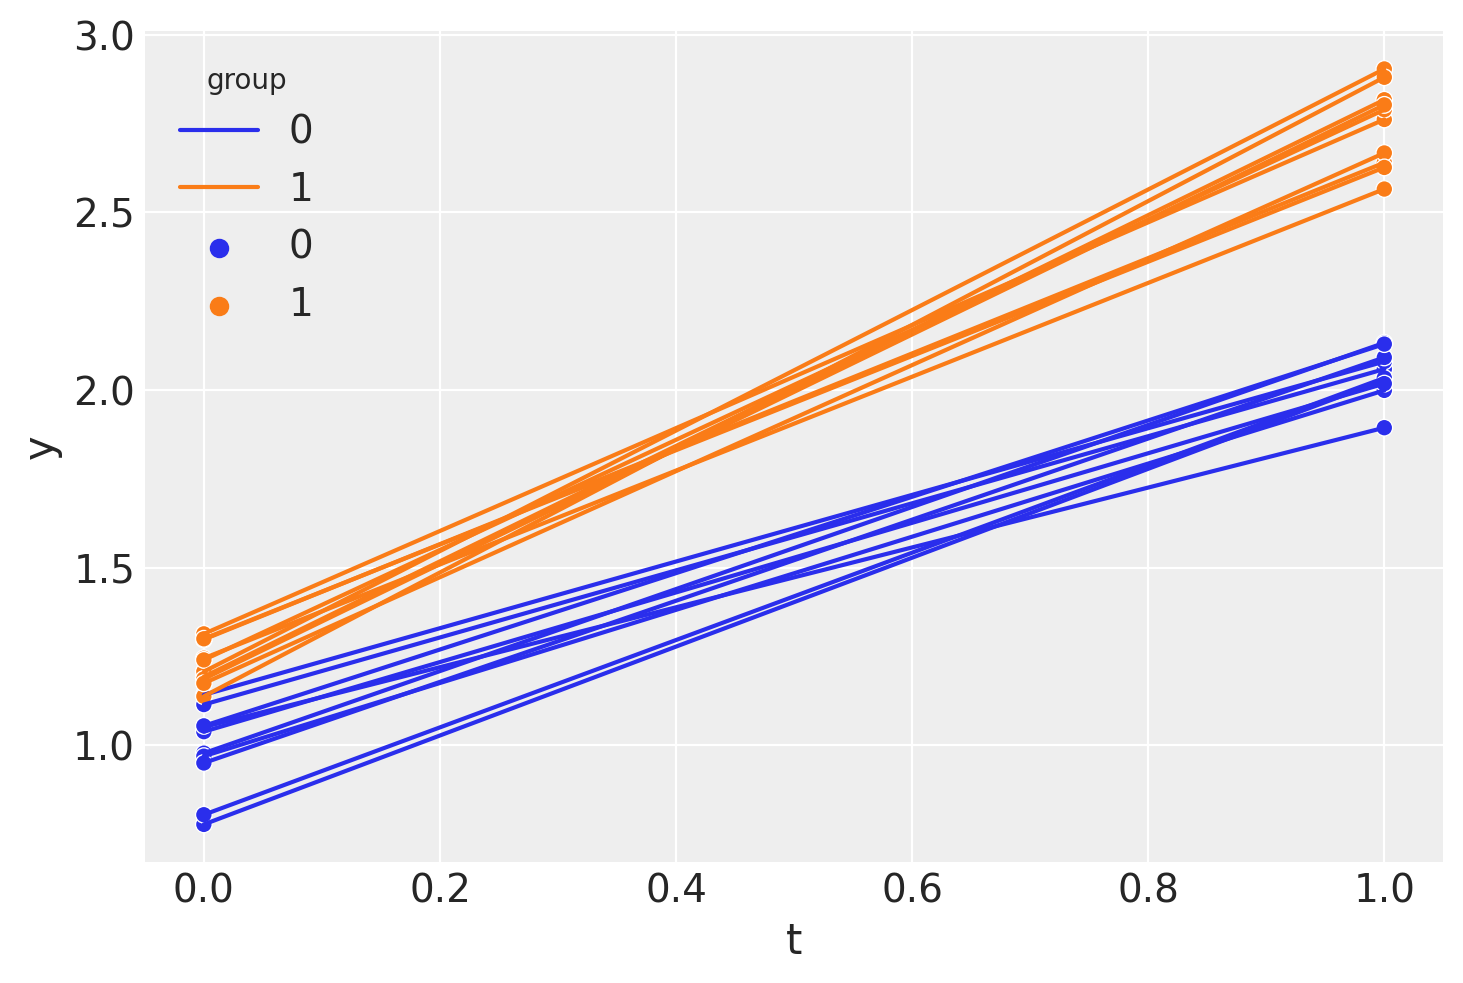

In [8]:
sns.lineplot(df, x="t", y="y", hue="group", units="unit", estimator=None)
sns.scatterplot(df, x="t", y="y", hue="group");

In [9]:
diff_control = (
    df.loc[(df["t"] == 1) & (df["group"] == 0)]["y"].mean()
    - df.loc[(df["t"] == 0) & (df["group"] == 0)]["y"].mean()
)
print(f"Pre/post difference in control group = {diff_control:.2f}")

diff_treat = (
    df.loc[(df["t"] == 1) & (df["group"] == 1)]["y"].mean()
    - df.loc[(df["t"] == 0) & (df["group"] == 1)]["y"].mean()
)

print(f"Pre/post difference in treatment group = {diff_treat:.2f}")

diff_in_diff = diff_treat - diff_control
print(f"Difference in differences = {diff_in_diff:.2f}")

Pre/post difference in control group = 1.06
Pre/post difference in treatment group = 1.52
Difference in differences = 0.46


In [10]:
with pm.Model() as model:
    # data
    t = pm.MutableData("t", df["t"].values, dims="obs_idx")
    treated = pm.MutableData("treated", df["treated"].values, dims="obs_idx")
    group = pm.MutableData("group", df["group"].values, dims="obs_idx")
    # priors
    _control_intercept = pm.Normal("control_intercept", 0, 5)
    _treat_intercept_delta = pm.Normal("treat_intercept_delta", 0, 1)
    _trend = pm.Normal("trend", 0, 5)
    _Δ = pm.Normal("Δ", 0, 1)
    sigma = pm.HalfNormal("sigma", 1)
    # expectation
    mu = pm.Deterministic(
        "mu",
        outcome(t, _control_intercept, _treat_intercept_delta, _trend, _Δ, group, treated),
        dims="obs_idx",
    )
    # likelihood
    pm.Normal("obs", mu, sigma, observed=df["y"].values, dims="obs_idx")

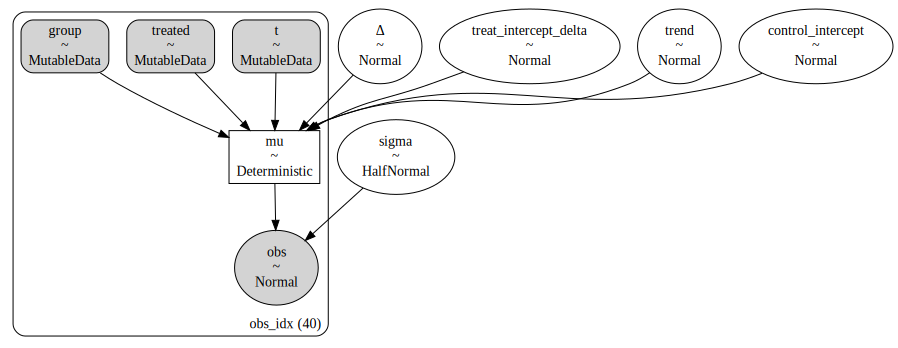

In [11]:
pm.model_to_graphviz(model)

In [12]:
with model:
    idata = pm.sample()

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


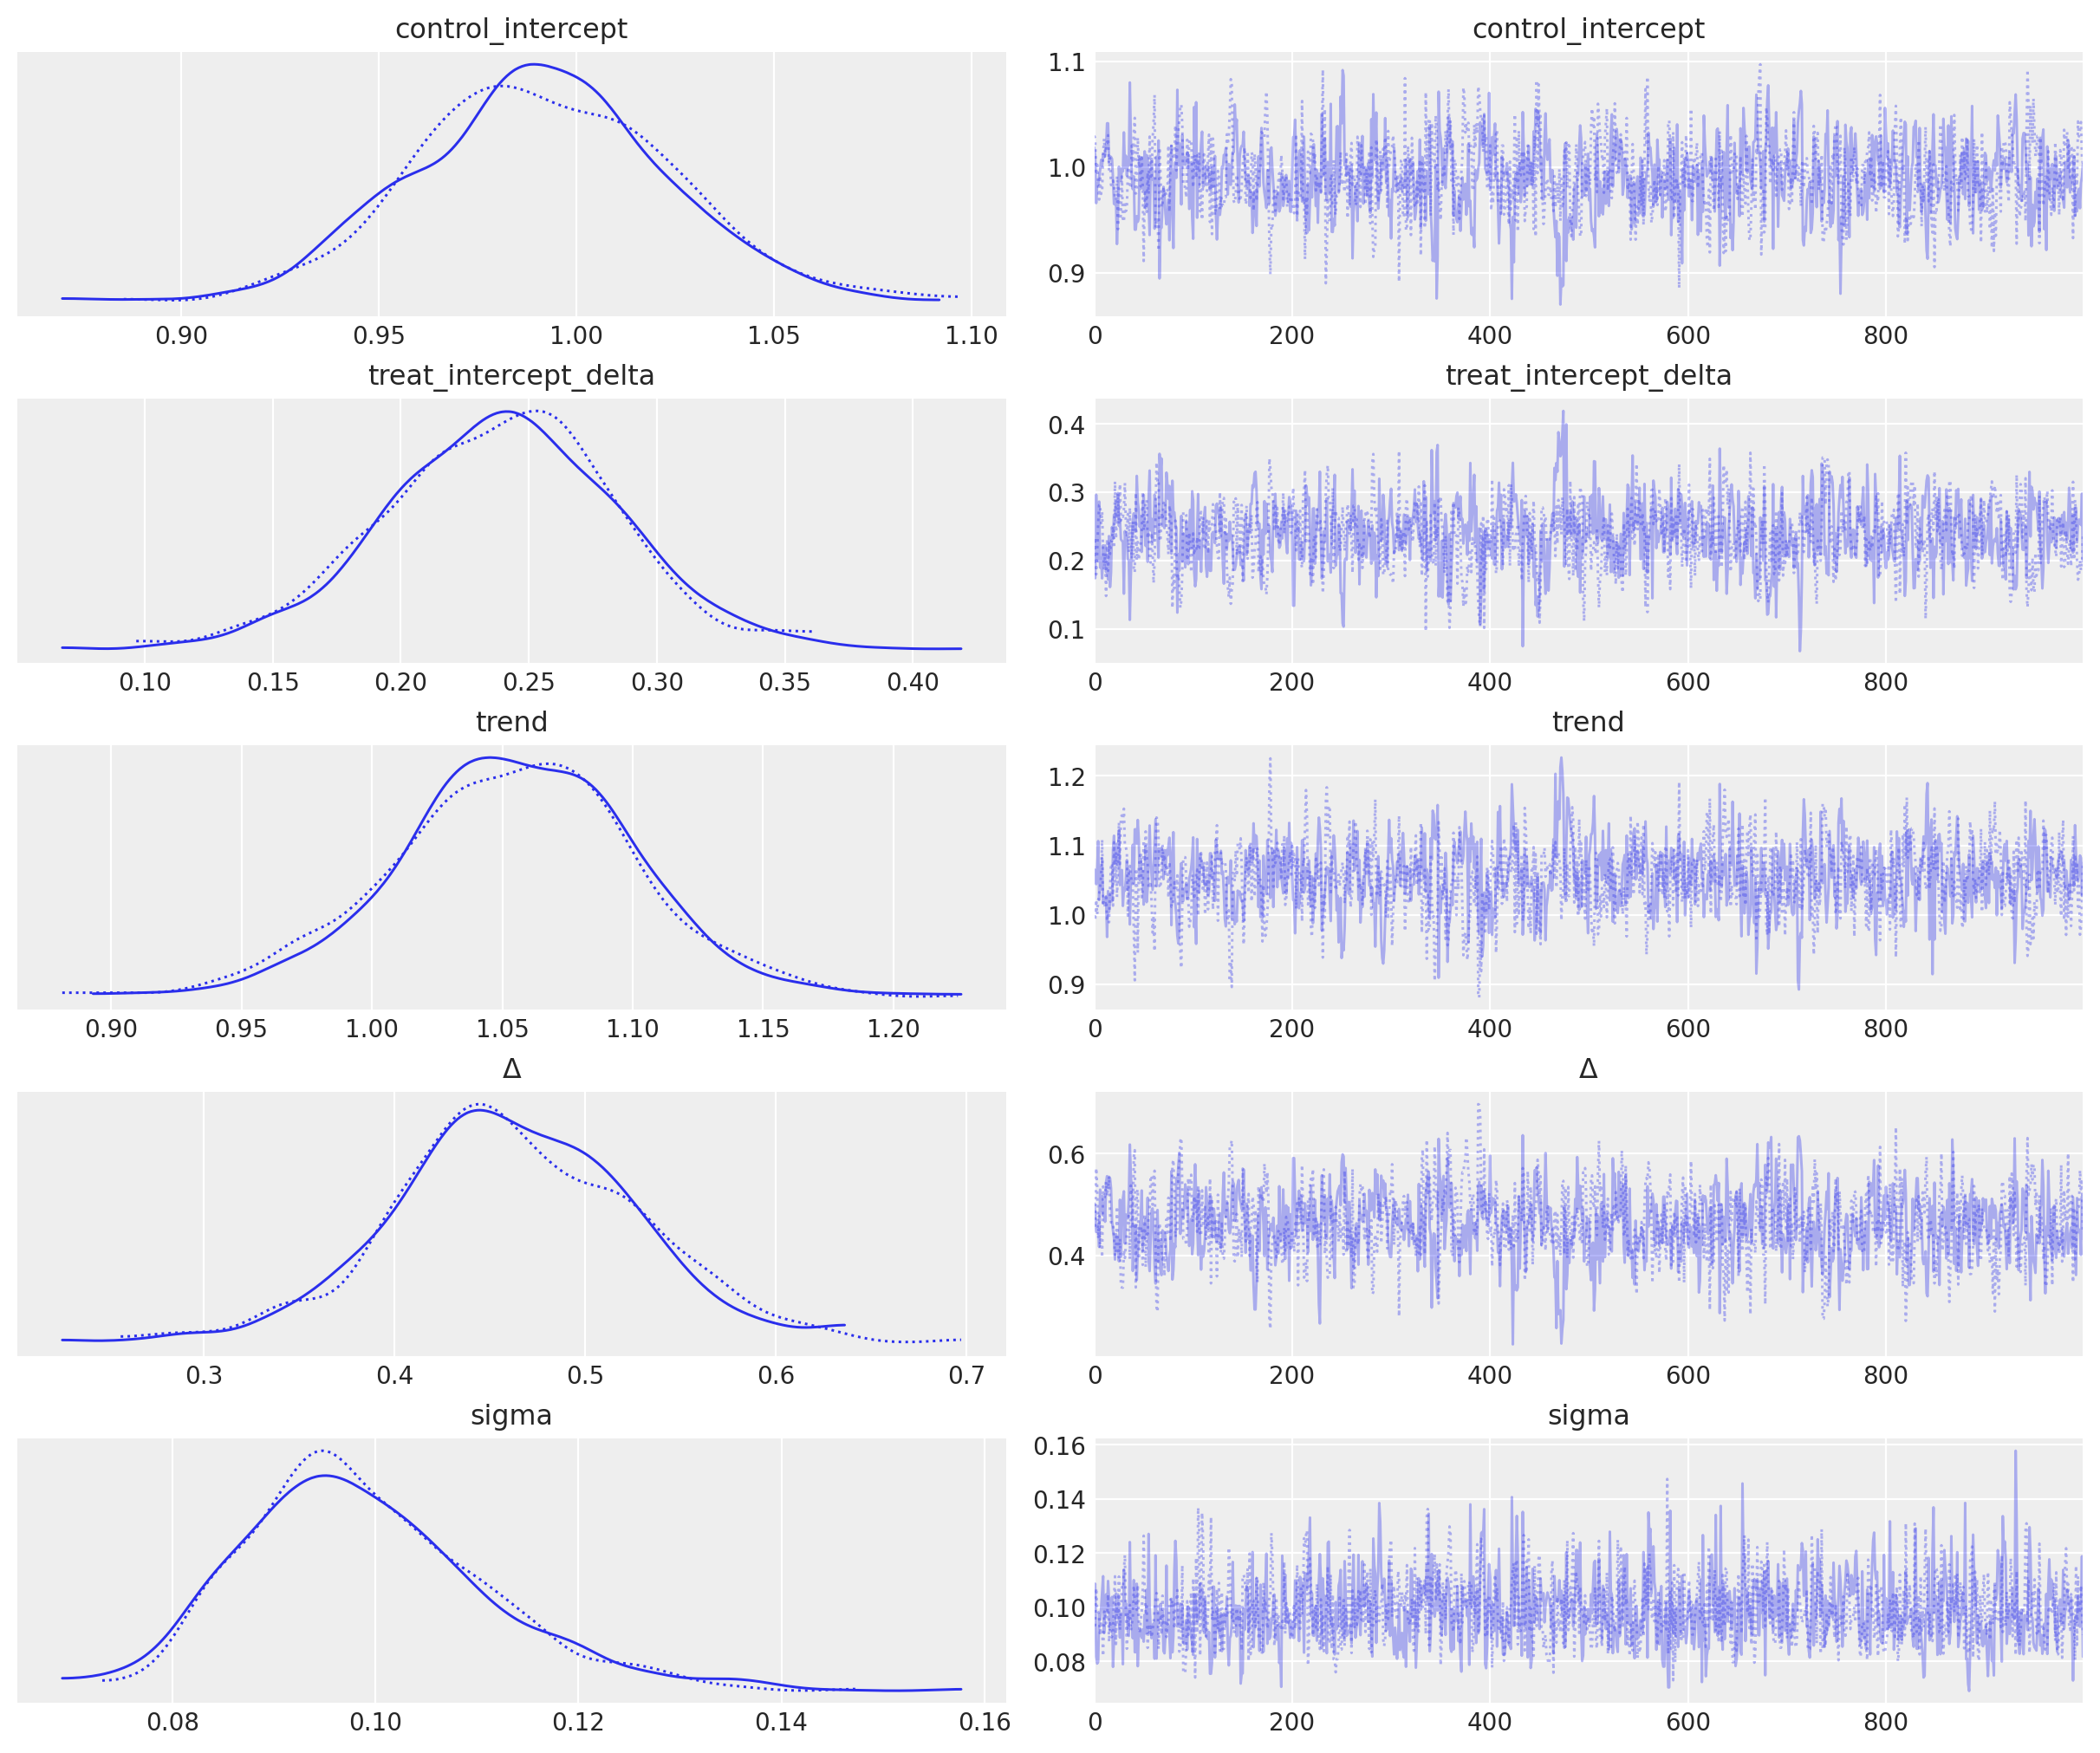

In [13]:
az.plot_trace(idata, var_names="~mu");

In [14]:
# pushforward predictions for control group
with model:
    group_control = [0] * len(ti)  # must be integers
    treated = [0] * len(ti)  # must be integers
    pm.set_data({"t": ti, "group": group_control, "treated": treated})
    ppc_control = pm.sample_posterior_predictive(idata, var_names=["mu"])

# pushforward predictions for treatment group
with model:
    group = [1] * len(ti)  # must be integers
    pm.set_data(
        {
            "t": ti,
            "group": group,
            "treated": is_treated(ti, intervention_time, group),
        }
    )
    ppc_treatment = pm.sample_posterior_predictive(idata, var_names=["mu"])

# counterfactual: what do we predict of the treatment group (after the intervention) if
# they had _not_ been treated?
t_counterfactual = np.linspace(intervention_time, 1.5, 100)
with model:
    group = [1] * len(t_counterfactual)  # must be integers
    pm.set_data(
        {
            "t": t_counterfactual,
            "group": group,
            "treated": [0] * len(t_counterfactual),  # THIS IS OUR COUNTERFACTUAL
        }
    )
    ppc_counterfactual = pm.sample_posterior_predictive(idata, var_names=["mu"])

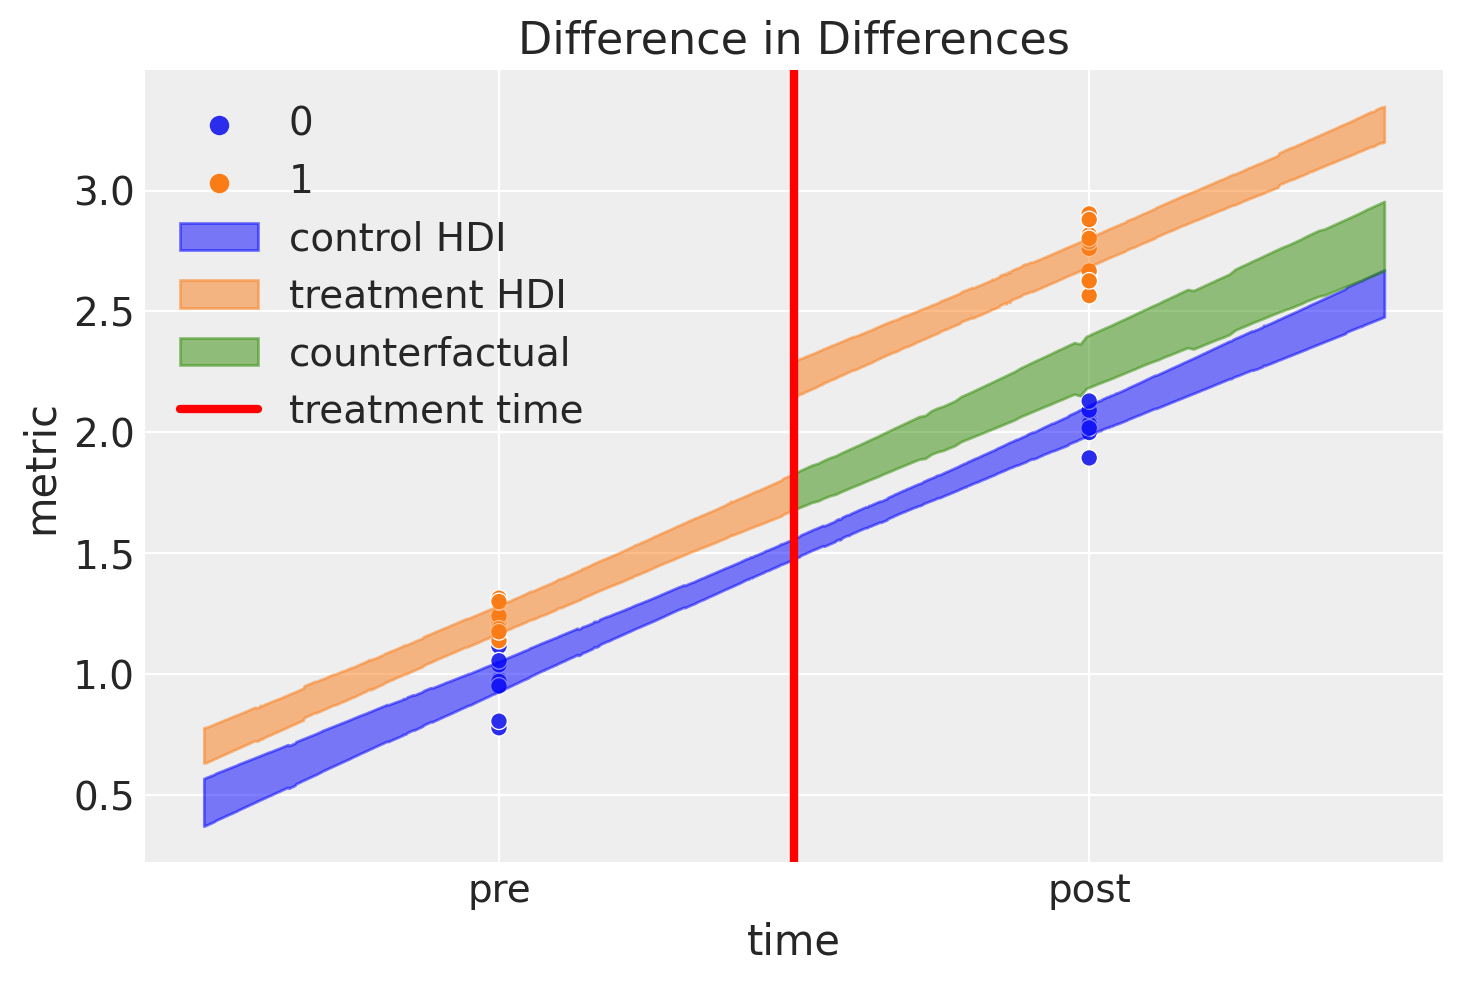

In [15]:
ax = sns.scatterplot(df, x="t", y="y", hue="group")

az.plot_hdi(
    ti,
    ppc_control.posterior_predictive["mu"],
    smooth=False,
    ax=ax,
    color="blue",
    fill_kwargs={"label": "control HDI"},
)
az.plot_hdi(
    ti,
    ppc_treatment.posterior_predictive["mu"],
    smooth=False,
    ax=ax,
    color="C1",
    fill_kwargs={"label": "treatment HDI"},
)
az.plot_hdi(
    t_counterfactual,
    ppc_counterfactual.posterior_predictive["mu"],
    smooth=False,
    ax=ax,
    color="C2",
    fill_kwargs={"label": "counterfactual"},
)
ax.axvline(x=intervention_time, ls="-", color="r", label="treatment time", lw=3)
ax.set(
    xlabel="time",
    ylabel="metric",
    xticks=[0, 1],
    xticklabels=["pre", "post"],
    title="Difference in Differences",
)
ax.legend();

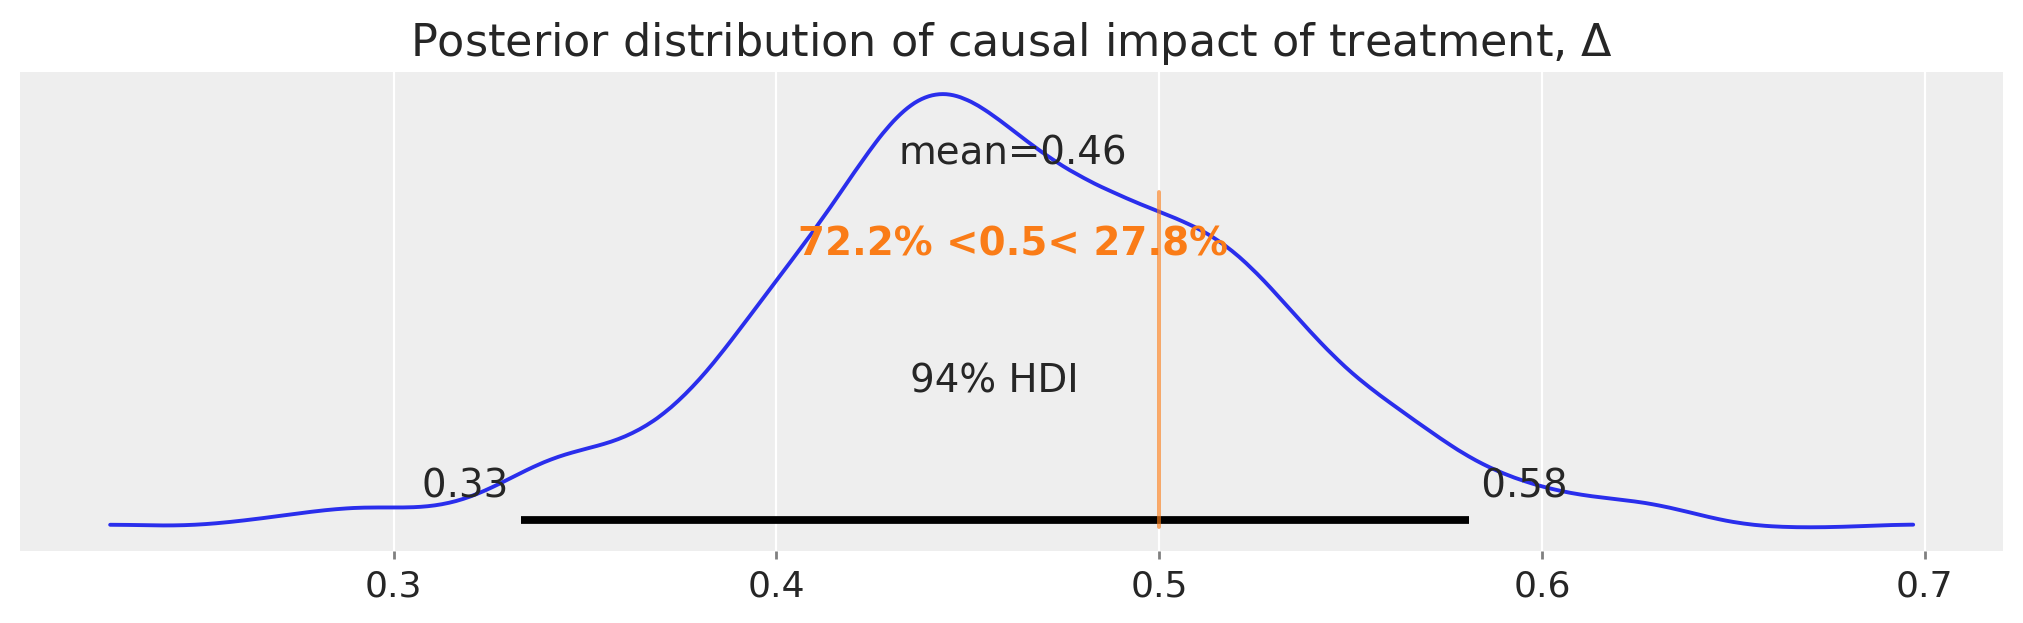

In [16]:
ax = az.plot_posterior(idata.posterior["Δ"], ref_val=Δ, figsize=(10, 3))
ax.set(title=r"Posterior distribution of causal impact of treatment, $\Delta$");

In [17]:
!pip install watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.7 MB/s eta 0:00:00


In [18]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,aeppl,xarray

Last updated: Fri Dec 15 2023

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

pytensor: 2.14.2
aeppl   : not installed
xarray  : 2023.7.0

seaborn   : 0.12.2
matplotlib: 3.7.1
arviz     : 0.15.1
pymc      : 5.7.2
pandas    : 1.5.3
numpy     : 1.23.5

Watermark: 2.4.3

